<a href="https://colab.research.google.com/github/eflores5000/estrategia2/blob/main/RNN_con_Vegetable_MobileNetV2_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install -q -U keras-tuner
import tensorflow as tf
from keras.datasets import mnist
from keras import layers, models
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.callbacks import Callback
import kerastuner as kt
from keras import callbacks
from keras import optimizers
from keras import models
from google.colab import files
!pip install quickdraw
from quickdraw import QuickDrawData
from google.colab import output
import os
import math
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import MobileNetV2


In [2]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [3]:
#%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()
#uploaded = files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eduflowers","key":"8cf8eb7e9d3d4d836fe29bda7df108d9"}'}

In [4]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Descarguemos un dataset de cierta competición
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vegetable-image-dataset


In [6]:
# Creamos un directorio para descomprimir los datos
#!cp -r /root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1 my_dataset
#!mkdir my_dataset

In [ ]:
# Descomprimimos los datos y los dejamos listos para trabajar
#!unzip dogs-vs-cats-redux-kernels-edition.zip -d my_dataset
#!unzip my_dataset/test.zip
#%%capture
#!ls test/


In [7]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[INFO]: Clases disponibles: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


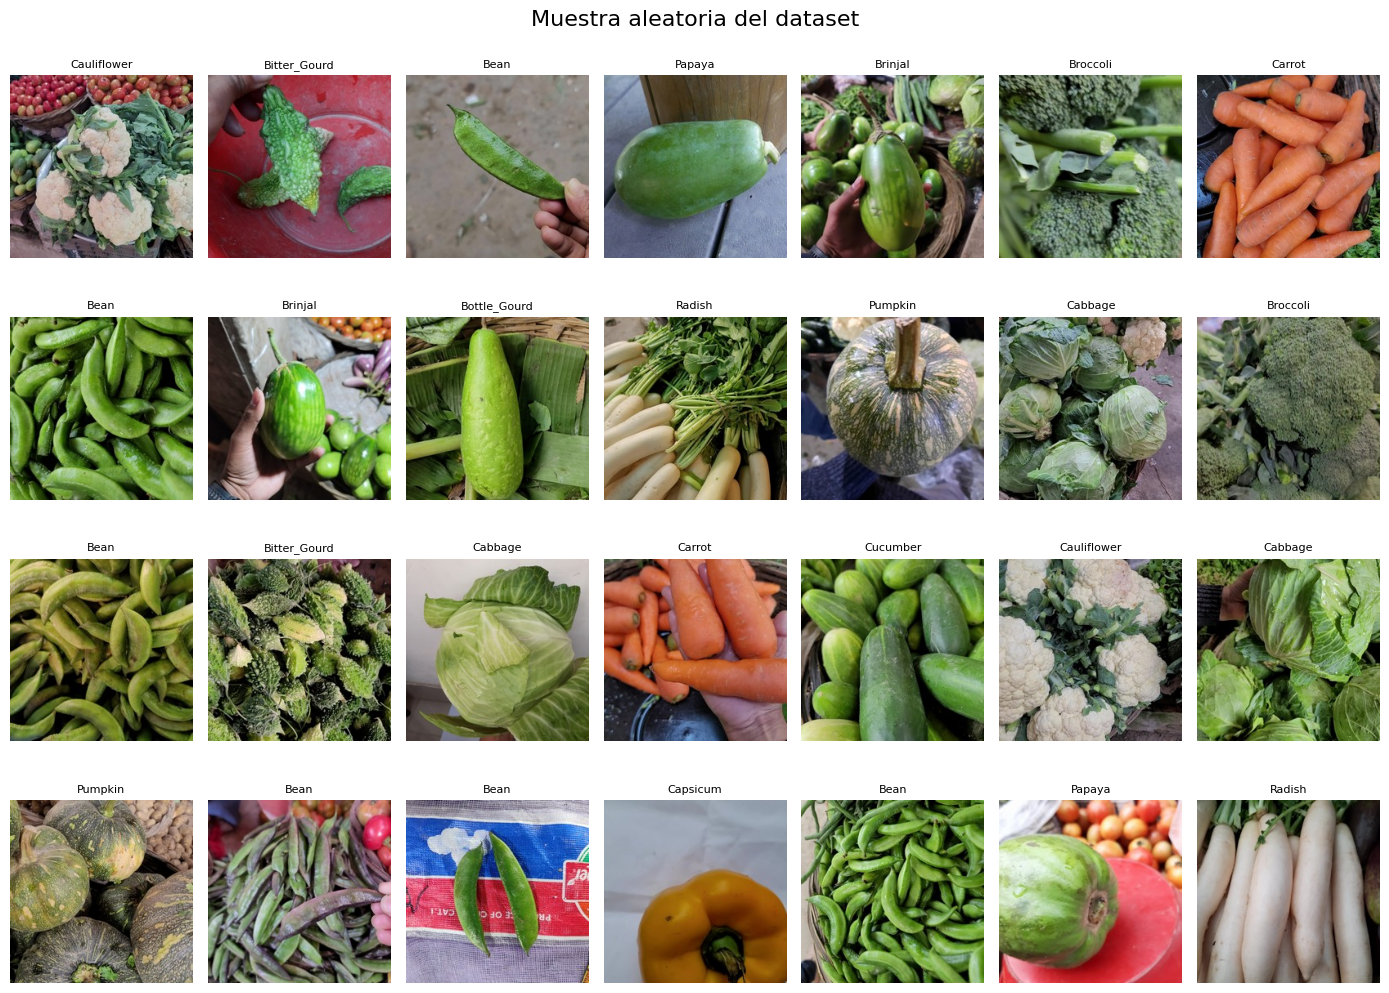

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Ruta al dataset de entrenamiento
train_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'

# Obtener solo carpetas (clases) válidas
clases = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
print(f"[INFO]: Clases disponibles: {clases}")

# Preparar lista de (imagen, etiqueta)
ejemplos = []
for clase in clases:
    ruta_clase = os.path.join(train_path, clase)
    imagenes = [f for f in os.listdir(ruta_clase) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img in imagenes:
        ejemplos.append((os.path.join(ruta_clase, img), clase))

# Seleccionar aleatoriamente 28 imágenes
muestras = random.sample(ejemplos, 28)

# Visualización tipo CIFAR-10
fig = plt.figure(figsize=(14, 10))
for i, (ruta_img, etiqueta) in enumerate(muestras):
    fig.add_subplot(4, 7, i+1)
    img = Image.open(ruta_img).resize((224, 224))
    plt.imshow(img)
    plt.title(etiqueta, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Muestra aleatoria del dataset", fontsize=16, y=1.02)
plt.show()

In [43]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

imgs_w = 224
imgs_h = 224

train_dir_base = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
val_dir_base = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'
test_dir_base = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'

# Usamos un “data generator” para tener un dataset más grande.
# Básicamente ésto lo que hace es crear imágenes nuevas a partir del dataset original.
# Lo hace aplicando transformaciones como zoom, traslación o rotación.

# Preprocesamiento específico para MobileNetV2
def preprocess_input(x):
    return tf.keras.applications.mobilenet_v2.preprocess_input(x, data_format='channels_last')

# Aumentación de datos para entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Generador de validación (solo preprocesamiento)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Para validación
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
  train_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'rgb',
  subset = 'training'
)
val_generator = val_datagen.flow_from_directory(
  val_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'rgb'
)

test_generator = test_datagen.flow_from_directory(
  test_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'rgb'
)


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [44]:
# Buscamos los hyperparámetros ideales para nuestro modelo.

def model_generator(hp):

  # Cargar modelo base preentrenado
  base_model = MobileNetV2(
      weights='imagenet',
      include_top=False,
      input_shape=(imgs_w,imgs_h, 3)
  )

  # Congelar inicialmente
  base_model.trainable = False  # Congelar inicialmente

  num_classes = train_generator.num_classes

  # numero filtros convoluciones
  filters = hp.Choice('filters', values=[32, 64, 128]) #numero de neuronas
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_units = hp.Int('units', min_value = 32, max_value=512, step=32) # hidden layers:
  #hp_units = hp.Int('units', min_value=64, max_value=512, step=64)

  # Arquitectura optimizada para MobileNetV2
  inputs = tf.keras.Input(shape=(imgs_w,imgs_h, 3))
  x = base_model(inputs, training=False)

  #model = models.Sequential() # convolution layers:

  # Bloque 1
  x=layers.Conv2D(filters, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  x=layers.Conv2D(filters, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  print(x.shape)
  x=layers.MaxPool2D((2,2))(x)

  # Bloque 2
  x=layers.Conv2D(filters*2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  x=layers.Conv2D(filters*2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  print(x.shape)
  x=layers.MaxPool2D((2,2))(x)
  x=layers.Dropout(0.3)(x)

  # Bloque 3
  x=layers.Conv2D(filters*4, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  x=layers.Conv2D(filters*4, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  print(x.shape)
  #x=layers.MaxPool2D((2,2))(x)
  x=layers.Dropout(0.4)(x)  # capa del input del clasificador:

  # Clasificador
  x=layers.Flatten()(x)     #numero de neuronas

  # Red oculta opcional:
  x=layers.Dense(units = hp_units, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  #x=layers.Dense(units = int(hp_units/2), activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)

  x=layers.Dropout(0.2)(x) # output layer

  # Capa de salida
  outputs=layers.Dense(num_classes,activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  # Compilación
  model.compile(optimizer= optimizers.Adam(learning_rate=hp_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

tuner = kt.Hyperband(
  model_generator,
  objective = 'val_accuracy',
  max_epochs = 1,
  directory = 'models',
  project_name = 'psm'
)

tuner.search(train_generator, epochs = 1, validation_data=val_generator)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps)

# Mejor combinación
print(f"🔎 Mejores hiperparámetros encontrados:")
print(f"  - Filtros: {best_hps.get('filters')}")
print(f"  - Learning rate: {best_hps.get('learning_rate')}")
#print(f"  - Neuronas en capa densa: {best_hps.get('units')}")


Reloading Tuner from models/psm/tuner0.json
🔎 Mejores hiperparámetros encontrados:
  - Filtros: 32
  - Learning rate: 0.001


In [45]:
# Por aquí personalizamos un callback que se llamará cada época para detener el
# entrenamiento si llegamos al 0.99 de accuracy en los datos de validación.

class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.99:
      print('Model reached 99,9% of accuracy. Stopping training.')
      self.model.stop_training = True


In [56]:
#Configuramos el criterio para guardar los pesos del modelo para que se guarde el
#punto del entrenamiento con mejor accuracy en los datos de validación.

checkpoint_save = callbacks.ModelCheckpoint(
  filepath = 'model_checkpoints/checkpoint.h5',
  save_freq = 'epoch',
  save_weights_only = False,
  monitor = 'val_accuracy',
  save_best_only = True,
  verbose = 1
)

# Verificación
print(f"Número de clases en train: {train_generator.num_classes}")
print(f"Número de clases en val: {val_generator.num_classes}")
print(f"Mapping de clases: {train_generator.class_indices}")
print(f"Mapping de clases: {val_generator.class_indices}")

Número de clases en train: 15
Número de clases en val: 15
Mapping de clases: {'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9, 'Papaya': 10, 'Potato': 11, 'Pumpkin': 12, 'Radish': 13, 'Tomato': 14}
Mapping de clases: {'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9, 'Papaya': 10, 'Potato': 11, 'Pumpkin': 12, 'Radish': 13, 'Tomato': 14}


In [47]:
#Instanciamos el modelo con los parámetros más eficientes.
model = model_generator(best_hps)

(None, 7, 7, 32)
(None, 3, 3, 64)
(None, 1, 1, 128)


In [ ]:
#Si ya lo tuviéramos guardado, lo gargaríamos del siguiente modo:
#model = models.load_model(“model_checkpoints/checkpoint”)


In [48]:
#print("\n--- Fase 1: Transfer Learning ---")

#Procedemos al entrenamiento:
train_epochs = 10
early_stop_patience = 3
train_history = model.fit(
  train_generator,
  epochs=train_epochs,
  batch_size=128,
  validation_data=val_generator,
  callbacks = [
  checkpoint_save,
  #TrainingCallback(),
  callbacks.EarlyStopping(monitor = 'val_loss', patience=10, mode = 'auto')
  ] )

base_model.save('final_model_MobileNetV2.h5')
print("✅ Modelo guardado como 'final_model_MobileNetV2.h5'.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3491 - loss: 1.8048
Epoch 1: val_accuracy improved from -inf to 0.96433, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.3510 - loss: 1.7990 - val_accuracy: 0.9643 - val_loss: 0.1864
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9232 - loss: 0.2311
Epoch 2: val_accuracy improved from 0.96433 to 0.98933, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9234 - loss: 0.2307 - val_accuracy: 0.9893 - val_loss: 0.0486
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9801 - loss: 0.0905
Epoch 3: val_accuracy improved from 0.98933 to 0.99000, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9801 - loss: 0.0904 - val_accuracy: 0.9900 - val_loss: 0.0445
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9849 - loss: 0.0647
Epoch 4: val_accuracy improved from 0.99000 to 0.99300, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9849 - loss: 0.0647 - val_accuracy: 0.9930 - val_loss: 0.0392
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9890 - loss: 0.0567
Epoch 5: val_accuracy improved from 0.99300 to 0.99433, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9890 - loss: 0.0567 - val_accuracy: 0.9943 - val_loss: 0.0325
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9887 - loss: 0.0621
Epoch 6: val_accuracy improved from 0.99433 to 0.99567, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9887 - loss: 0.0621 - val_accuracy: 0.9957 - val_loss: 0.0250
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9951 - loss: 0.0324
Epoch 7: val_accuracy improved from 0.99567 to 0.99633, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9951 - loss: 0.0324 - val_accuracy: 0.9963 - val_loss: 0.0248
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9903 - loss: 0.0548
Epoch 8: val_accuracy did not improve from 0.99633
118/118 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9903 - loss: 0.0548 - val_accuracy: 0.9950 - val_loss: 0.0300
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9910 - loss: 0.0489
Epoch 9: val_accuracy did not improve from 0.99633
118/118 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9910 - loss: 0.0489 - val_accuracy: 0.9963 - val_loss: 0.0300
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9916 - loss: 0.0496
Epoch 10: val_accuracy did not improve from 0.99633
118/118 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9916 - loss: 0.0496 - val_accuracy: 0.9957 - val_loss: 0.0269


NameError: name 'base_model' is not defined

In [49]:
#Guardando modelo
model.save('final_model_MobileNetV2.h5')
print("✅ Modelo guardado como 'final_model_MobileNetV2.h5'.")


✅ Modelo guardado como 'final_model_MobileNetV2.h5'.


In [50]:
#Guardamos el modelo: ¡Qué no se pierda!
!zip -r /content/model_checkpoint.zip /content/model_checkpoints
files.download('/content/model_checkpoint.zip')


updating: content/model_checkpoints/ (stored 0%)
updating: content/model_checkpoints/checkpoint.h5 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# Fase 2: Fine-Tuning
print("\n--- Fase 2: Fine-Tuning ---")

model.trainable = True
for layer in model.layers[:100]:  # Descongelar solo capas superiores
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#checkpoint_save.set_model(model)  # <-- Manualmente se vincula el modelo

history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_save],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
    )

# ==========================
# Guardar modelo fine-tuning
# ==========================
model.save('final_MobileNetV2_finetuned.h5')
print("✅ Modelo afinado guardado como 'final_MobileNetV2_finetuned.h5'.")



--- Fase 2: Fine-Tuning ---
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9936 - loss: 0.0294
Epoch 1: val_accuracy improved from -inf to 0.99567, saving model to model_checkpoints/checkpoint.h5


118/118 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.9936 - loss: 0.0294 - val_accuracy: 0.9957 - val_loss: 0.0192
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9935 - loss: 0.0283
Epoch 2: val_accuracy did not improve from 0.99567
118/118 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9935 - loss: 0.0283 - val_accuracy: 0.9957 - val_loss: 0.0192
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9936 - loss: 0.0306
Epoch 3: val_accuracy did not improve from 0.99567
118/118 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9936 - loss: 0.0305 - val_accuracy: 0.9957 - val_loss: 0.0192
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9949 - loss: 0.0227
Epoch 4: val_accuracy did not improve from 0.99567
118/118 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9949 - loss: 0.0227 - val_accuracy: 0.9957 - val_loss: 0.0192
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9951 - loss: 0.0229
Epoch 5: val_accuracy did not impro

✅ Modelo afinado guardado como 'final_MobileNetV2_finetuned.h5'.


In [59]:
#Observamos los resultados:

results = model.evaluate(train_generator)

118/118 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9960 - loss: 0.0191


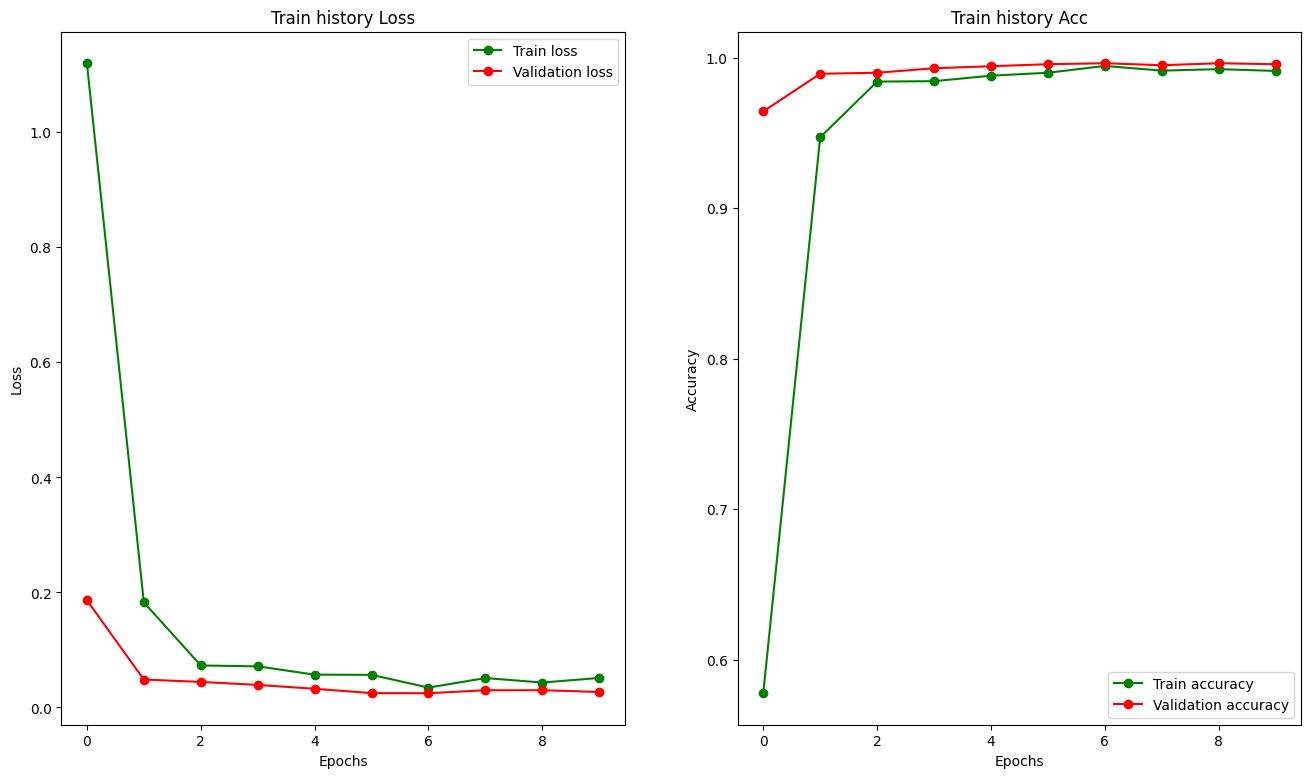

In [60]:
# Función para graficar entrenamiento:

#@title Función para graficar entrenamiento
def show_train_history(history, show_acc = True):
  epochs = [i for i in range(len(history.history['accuracy']))]
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig, ax = plt.subplots(1, 2 if show_acc else 1)
  fig.set_size_inches(16 if show_acc else 10, 9)
  if show_acc:
    ax[1].plot(epochs, train_acc, 'go-', label = 'Train accuracy')
    ax[1].plot(epochs, val_acc, 'ro-', label = 'Validation accuracy')
    ax[1].set_title('Train history Acc')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[0].plot(epochs, train_loss, 'go-', label = 'Train loss')
    ax[0].plot(epochs, val_loss, 'ro-', label = 'Validation loss')
    ax[0].set_title('Train history Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
  else:
    ax.plot(epochs, train_loss, 'go-', label = 'Train loss')
    ax.plot(epochs, val_loss, 'ro-', label = 'Validation loss')
    ax.set_title('Train history Loss')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
  plt.show()

show_train_history(train_history)

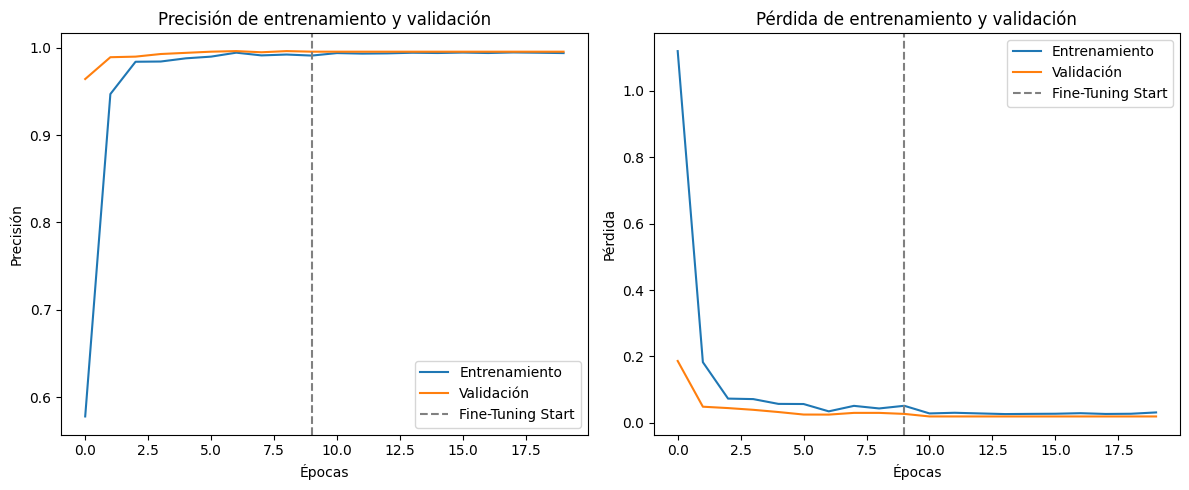

In [61]:
import matplotlib.pyplot as plt

# Combinamos precisión de entrenamiento
acc = train_history.history['accuracy'] + history_fine.history['accuracy']
val_acc = train_history.history['val_accuracy'] + history_fine.history['val_accuracy']

# Combinamos pérdidas
loss = train_history.history['loss'] + history_fine.history['loss']
val_loss = train_history.history['val_loss'] + history_fine.history['val_loss']

# Número total de épocas
epochs_range = range(len(acc))

# Graficar
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.axvline(x=len(train_history.history['accuracy']) - 1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.axvline(x=len(train_history.history['loss']) - 1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()
